In [1]:
import hdf5storage as hdf
import tensorflow as tf
import im_model as tm
import numpy as np
import math 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print(tf.VERSION)

1.10.0


In [3]:
data = []
for i in range(100):
    loc = i+1
    filepath = '/home/charlieniu21/code/Deep-ADMM-Net/data/ChestTrain/im-'
    if loc < 10 :
        fp = filepath+'0'+str(loc)+'.mat'
    else:
        fp = filepath+str(loc)+'.mat'
    d = hdf.loadmat(fp)
    d_true = np.array(d['im_ori'])
    data.append(d_true)

In [4]:
mask = hdf.loadmat('/home/charlieniu21/code/Deep-ADMM-Net/mask/mask_10.mat')
mask = np.array(mask['mask'])
mask = np.fft.ifftshift(mask)
mask = np.reshape(mask, [1, 256, 256])

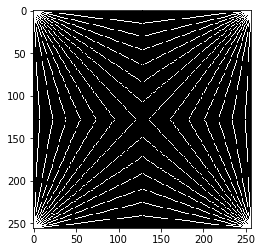

In [5]:
plt.imshow(np.reshape(mask,[256, 256]), cmap = "gray")

In [6]:
data = np.array(data)
data = np.reshape(data, [100, 256, 256, 1])

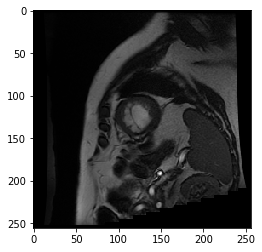

In [7]:
plt.imshow(np.reshape(data[10,:,:,:], [256, 256]), cmap = "gray")

In [8]:
def get_batch(size = 5):
    batch_loc = np.random.randint(100, size = size)
    return data[batch_loc, :, :, :]

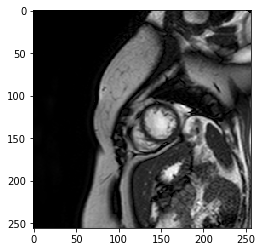

In [9]:
b1 = get_batch()
plt.imshow(np.reshape(b1[3,:,:,:], [256, 256]), cmap = "gray")

In [10]:
def get_masked(data, mask):
    with tf.device('/cpu:0'):
        d_complex = tf.reshape(tf.cast(data, tf.complex64),
                           [data.shape[0], 256, 256])
        mask_complex = tf.cast(mask, tf.complex64)
        d_kspace = tf.fft2d(d_complex)*mask_complex
        d_masked_complex = tf.ifft2d(d_kspace)
        d_masked_real = tf.reshape(tf.real(d_masked_complex), 
                               [d_masked_complex.get_shape()[0], 256, 256, 1])
        d_masked_imag = tf.reshape(tf.imag(d_masked_complex), 
                               [d_masked_complex.get_shape()[0], 256, 256, 1])
        d_masked = tf.concat([d_masked_real, d_masked_imag], axis = 3)
    with tf.Session() as sess:
        masked = sess.run(d_masked)
    return masked

In [11]:
masked = get_masked(b1, mask)

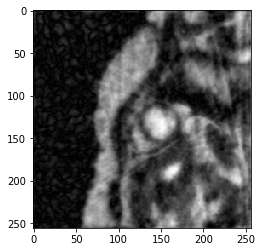

In [12]:
m1 = tf.cast(masked[3][:][:][:], tf.complex64)
re = m1[:,:,0]+1j*m1[:,:,1]
r = tf.abs(re)
r = tf.reshape(r, [256, 256])
with tf.Session() as sess:
    o1 = sess.run(r)
plt.imshow(o1, cmap = "gray")

In [13]:
batchsize = 5 # change it along with test_model.py
model_input_masked = tf.placeholder(tf.float32, [batchsize, 256, 256, 2], 
                                    "masked")
model_input_gtrue = tf.placeholder(tf.float32, [batchsize, 256, 256, 1], 
                                   "ground_truth")


In [14]:
gene_output, gene_output_complex, gene_var_list, gene_layers, disc_real_output, disc_fake_output, disc_var_list, disc_layers = tm.create_model(model_input_masked, model_input_gtrue, mask)
    
    
gene_loss, gene_dc_loss, gene_fool_loss, list_gene_lose, gene_mse_factor = tm.create_generator_loss(disc_fake_output, gene_output, gene_output_complex, model_input_masked, model_input_gtrue, mask)
    
    
disc_loss = tm.create_discriminator_loss(disc_real_output, disc_fake_output)
    
global_step, learning_rate, gene_minimize, disc_minimize = tm.create_optimizers(gene_loss, gene_var_list,disc_loss, disc_var_list)

use resnet without pooling: [64, 64, 64, 32, 16]
using Fourier, input dim (5, 256, 256, 2), output dim (5, 256, 256)
using Fourier, input dim (5, 256, 256, 2), output dim (5, 256, 256)
use resnet without pooling: [64, 64, 64, 32, 16]
using Fourier, input dim (5, 256, 256, 2), output dim (5, 256, 256)
using Fourier, input dim (5, 256, 256, 2), output dim (5, 256, 256)
use resnet without pooling: [64, 64, 64, 32, 16]
using Fourier, input dim (5, 256, 256, 2), output dim (5, 256, 256)
using Fourier, input dim (5, 256, 256, 2), output dim (5, 256, 256)
use resnet without pooling: [64, 64, 64, 32, 16]
using Fourier, input dim (5, 256, 256, 2), output dim (5, 256, 256)
using Fourier, input dim (5, 256, 256, 2), output dim (5, 256, 256)
use resnet without pooling: [64, 64, 64, 32, 16]
using Fourier, input dim (5, 256, 256, 2), output dim (5, 256, 256)
using Fourier, input dim (5, 256, 256, 2), output dim (5, 256, 256)
use resnet without pooling: [64, 64, 64, 32, 16]
using Fourier, input dim (

In [15]:
import time

def train_process(epochs = 20, batch_size = 5):
    gene_train_log = []
    disc_train_log = []
    train_time = 0
    while train_time<epochs:
        start_time = time.time()
        batch_true = get_batch(batch_size)
        batch_masked = get_masked(batch_true, mask)
        g_los, d_los = sess.run([gene_loss, disc_loss],feed_dict = {model_input_masked:batch_masked, model_input_gtrue:batch_true, learning_rate: 0.001})
        #print('done with loss')
        gene_train_log.append(g_los)
        disc_train_log.append(d_los)
        sess.run([gene_minimize,disc_minimize],feed_dict = {model_input_masked:batch_masked, model_input_gtrue:batch_true, learning_rate: 0.001})
        print("epoch: "+str(train_time)+", g_loss: "+str(g_los)+", d_loss: "+str(d_los)+" time_spent:"+str(time.time()-start_time)+"s")
        train_time += 1
    return (gene_train_log, disc_train_log)

In [16]:
sess = tf.Session()
init = tf.global_variables_initializer()
writer = tf.summary.FileWriter("logs/", sess.graph)
sess.run(init)

In [17]:
g_log, d_log = train_process(epochs = 500)

epoch: 0, g_loss: 16.081045, d_loss: 0.6669464 time_spent:11.014286279678345s
epoch: 1, g_loss: 412.0371, d_loss: 0.6801923 time_spent:3.7599551677703857s
epoch: 2, g_loss: 176.53879, d_loss: 0.6572439 time_spent:3.702763795852661s
epoch: 3, g_loss: 20.167925, d_loss: 0.65098643 time_spent:3.7334654331207275s
epoch: 4, g_loss: 18.730467, d_loss: 0.6467603 time_spent:3.7450311183929443s
epoch: 5, g_loss: 12.438487, d_loss: 0.66324866 time_spent:3.7129361629486084s
epoch: 6, g_loss: 12.052485, d_loss: 0.62800395 time_spent:3.6902406215667725s
epoch: 7, g_loss: 5.2886233, d_loss: 0.6274135 time_spent:3.7368879318237305s
epoch: 8, g_loss: 5.6138396, d_loss: 0.6277143 time_spent:3.802572727203369s
epoch: 9, g_loss: 3.4847665, d_loss: 0.61242855 time_spent:3.7440366744995117s
epoch: 10, g_loss: 3.3482578, d_loss: 0.61907256 time_spent:3.753990650177002s
epoch: 11, g_loss: 2.6502638, d_loss: 0.6267369 time_spent:3.7354297637939453s
epoch: 12, g_loss: 3.5014966, d_loss: 0.57881373 time_spent:3

In [18]:
saver=tf.train.Saver(max_to_keep=1)
pa = saver.save(sess,"/home/charlieniu21/code/GANCS/immodel/model_2.ckpt")

In [19]:
o2 = sess.run(gene_output,feed_dict = {model_input_masked:masked, model_input_gtrue:b1, learning_rate: 0.001})

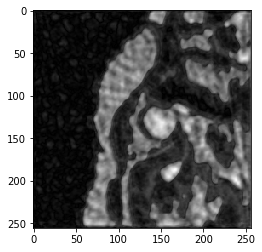

In [20]:
plt.imshow(np.reshape(o2[3,:,:,:], [256,256]), cmap = "gray")

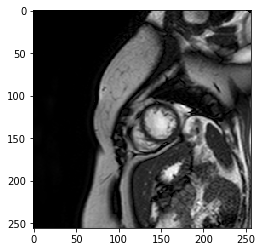

In [21]:
plt.imshow(np.reshape(b1[3,:,:,:], [256, 256]), cmap = "gray")

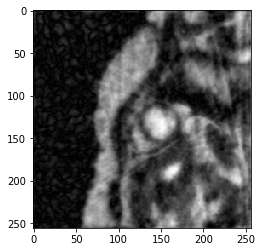

In [22]:
plt.imshow(o1, cmap = "gray")